# Прогноз оттока клиентов оператора связи

## Описание исследования
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

## Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Цель исследования
Построить модель для прогнозирования оттока клиентов.

## Задачи исследования

Исследовать данные и обучить на них модель, способную корректно спрогнозировать уход клиента от оператора, а также дать рекомендации для бизнеса заказчику.

## Исходные данные
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на *1 февраля 2020 года*.

## План исследования

***[Часть 1. Загрузка данных](#dataloading)***
* [1. contract_new](#contract_new)
* [2. personal_new](#personal_new)
* [3. internet_new](#internet_new)
* [4. phone_new](#phone_new)

***[Часть 2. Предобработка данных:](#datapreprocessing)***
* [1. Предобработка contract_new](#datapreprocessing)
* [2. Предобработка personal_new](#prep_personal_new)
* [3. Предобработка internet_new](#prep_internet_new)
* [4. Предобработка phone_new](#prep_phone_new)

***[Часть 3. Объединение данных](#joining)***

***[Часть 4. Исследовательский анализ](#eda)***

***[Часть 5. Корреляционный анализ](#corr)***

***[Часть 6. Обучение моделей:](#ml)***
* [1. Подготовка данных](#ml)
* [2. Моделирование и подбор гиперпараметров](#hyperparams)
* [2. Анализ модели](#model_analysis)

***[Часть 7. Вывод](#summary)***


<a id='dataloading'></a>
## Загрузка данных

Импортируем неоходимые библиотеки

In [2]:
!pip install snakecase -q
!pip install phik -q
!pip install lightgbm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

import snakecase
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score,\
                            precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

%matplotlib inline
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
plt.rc('figure', autolayout=True, figsize=(10, 7))
plt.rc('axes', titlesize=16, titlepad=10)

Загрузим данные в датафреймы

In [3]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

Рассмотрим основную информацию для каждого датасета

<a id='contract_new'></a>
### contract_new

Выведем первые 5 строк.

In [4]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Данные загружены верно. Посмотрим на основную информацию о датафрейме.

In [5]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Во время предобработки следует изменить типы значений некоторых столбцов.

Сделаем `customerID` индексным столбцом и приведём названия столбцов к *snake_case*.

In [6]:
contract_new.columns = map(snakecase.convert, contract_new.columns)
if ~contract_new['customer_id'].duplicated().sum():
    contract_new.set_index('customer_id', inplace=True)
contract_new.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<a id='personal_new'></a>
### personal_new

Выведем первые 5 строк.

In [7]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Посмотрим на основную информацию о датафрейме.

In [8]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Сделаем `customerID` индексным столбцом и приведём названия столбцов к *snake_case*.

In [9]:
personal_new.columns = map(snakecase.convert, personal_new.columns)
if ~personal_new['customer_id'].duplicated().sum():
    personal_new.set_index('customer_id', inplace=True)
personal_new.head()

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<a id='internet_new'></a>
### internet_new

Выведем первые 5 строк.

In [10]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Посмотрим на основную информацию о датафрейме.

In [11]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В этом датафрейме меньше строк, чем в предыдущих: потребуется обрабатывать пропуски.

Сделаем `customerID` индексным столбцом и приведём названия столбцов к *snake_case*.

In [12]:
internet_new.columns = map(snakecase.convert, internet_new.columns)
if ~internet_new['customer_id'].duplicated().sum():
    internet_new.set_index('customer_id', inplace=True)
internet_new.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<a id='phone_new'></a>
### phone_new

Выведем первые 5 строк.

In [13]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Посмотрим на основную информацию о датафрейме.

In [14]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В `phone_new`, как и в `internet_new`, строк меньше, чем в двух других датафреймах.

Сделаем `customerID` индексным столбцом и приведём названия столбцов к *snake_case*.

In [15]:
phone_new.columns = map(snakecase.convert, phone_new.columns)
if ~phone_new['customer_id'].duplicated().sum():
    phone_new.set_index('customer_id', inplace=True)
phone_new.head()

,multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Данные загружены и готовы к дальнейшей работе с ними.

<a id='datapreprocessing'></a>
## Предобработка данных

### Предобработка contract_new

#### Изменение типов данных

Ещё раз посмотрим на данные и типы значений признаков.

In [16]:
contract_new.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [17]:
contract_new.dtypes

begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
dtype: object

Приведём `begin_date` к *datetime* и сделаем `total_charge` числовым.

In [18]:
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'])
contract_new['total_charges'] = pd.to_numeric(contract_new['total_charges'], errors='coerce')
contract_new.dtypes

begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

Посмотрим на статистическую информацию о датафрейме.

In [19]:
contract_new.describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


Действительно неожиданных значений нет. Максимальная дата в `begin_date` – `2020-02-01`: это хорошо, так как заявлено, что информация о договорах актуальна на 1 февраля 2020 года

#### Наличие пропусков и дубликатов

In [20]:
print('Число полных дубликатов:', contract_new.duplicated().sum())
display(contract_new[contract_new.duplicated(keep=False)].sort_values(['total_charges']))

Число полных дубликатов: 37


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
9441-QHEVC,2020-01-01,No,Month-to-month,No,Mailed check,19.10,19.10
6569-KTMDU,2020-01-01,No,Month-to-month,No,Mailed check,19.10,19.10
3373-YZZYM,2020-01-01,No,Month-to-month,No,Mailed check,19.20,19.20
1663-MHLHE,2020-01-01,No,Month-to-month,No,Mailed check,19.20,19.20
3679-XASPY,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
...,...,...,...,...,...,...,...
1307-ATKGB,2018-02-01,No,Month-to-month,Yes,Electronic check,89.55,2149.20
2990-IAJSV,2014-02-01,No,Two year,No,Bank transfer (automatic),92.00,6624.00
3084-DOWLE,2014-02-01,No,Two year,No,Bank transfer (automatic),92.00,6624.00


Возможно, после объединения датафреймов повторяющиеся записи станут уникальными, пока что удалять их не будем.

Выведем количество пропущенных значений в каждом столбце.

In [21]:
contract_new.isna().sum()

begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64

Есть 11 пропусков в столбце `total_charges`: посмотрим на них.

In [22]:
contract_new[contract_new['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


Все записи, в которых пропущены общие расходы абонента, имеют дату начала контракта, совпадающую с датой последней актуальной информации в датафрейме. При этом столбец `monthly_charges` непустой: заполним недостающие значения данными из этого столбца.

In [23]:
contract_new.loc[contract_new['total_charges'].isna(), 'total_charges'] = \
                            contract_new[contract_new['total_charges'].isna()]['monthly_charges']
contract_new[contract_new['begin_date'] == '2020-02-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70


Выведем уникальные значения категориальных столбцов.

In [24]:
for col in contract_new.select_dtypes(include='object').columns:
    print(f'Уникальные значения столбца {col}:')
    print(contract_new[col].unique(), '\n')

Уникальные значения столбца end_date:
['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01'] 

Уникальные значения столбца type:
['Month-to-month' 'One year' 'Two year'] 

Уника

Неявных дубликатов и неожиданных значений не видно.

#### Добавление столбца

Добавим столбец `period` с длительностью контракта.

In [25]:
contract_new['period'] = \
        (pd.to_datetime(contract_new['end_date'], errors='coerce') - contract_new['begin_date']).dt.days
contract_new

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,period
customer_id,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,NaN
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,NaN
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,NaN
...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,NaN
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,NaN
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,NaN


Так как информация о договорах актуальна на 1 февраля 2020 года, заполним пропуски в новом столбце длительностью контракта до этого дня.

In [26]:
contract_new['period'].fillna((pd.to_datetime('2020-02-01') - contract_new['begin_date']).dt.days, inplace=True)
contract_new.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,period
customer_id,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31.0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1036.0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,123.0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1371.0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,153.0
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,337.0
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671.0
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,306.0
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,945.0


#### Выделение целевого признака

Теперь, имея столбец с длительностью договоров, знание даты окончания его действия избыточно. Сделаем столбец `end_date` столбцом целевого признака: изменим значения **'No'** на **0**, а остальные – на **1**. Также переименум столбец в `quit`.

In [27]:
contract_new.loc[:, 'end_date'] = contract_new['end_date'].where(contract_new['end_date'] == 'No', 1).replace('No', 0)
contract_new.rename(columns={'end_date': 'quit'}, inplace=True)
contract_new.head(10)

,begin_date,quit,type,paperless_billing,payment_method,monthly_charges,total_charges,period
customer_id,,,,,,,,
7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,31.04,31.0
5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,2071.84,1036.0
3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,226.17,123.0
7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1960.60,1371.0
9237-HQITU,2019-09-01,0,Month-to-month,Yes,Electronic check,70.70,353.50,153.0
9305-CDSKC,2019-03-01,0,Month-to-month,Yes,Electronic check,99.65,1150.96,337.0
1452-KIOVK,2018-04-01,0,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671.0
6713-OKOMC,2019-04-01,0,Month-to-month,No,Mailed check,29.75,300.48,306.0
7892-POOKP,2017-07-01,0,Month-to-month,Yes,Electronic check,104.80,3573.68,945.0


Изменим тип столбцов `object` на `category` для экономии оперативной памяти.

In [28]:
for col in list(contract_new.select_dtypes(include='object').columns) + ['quit']:
    contract_new[col] = contract_new[col].astype('category')
contract_new.dtypes

begin_date           datetime64[ns]
quit                       category
type                       category
paperless_billing          category
payment_method             category
monthly_charges             float64
total_charges               float64
period                      float64
dtype: object

Убедимся в отсутствии пропусков.

In [29]:
contract_new.isna().sum()

begin_date           0
quit                 0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
period               0
dtype: int64

Теперь столбцы в `contract_new` приведены к правильным типам данных, а пропуски в них заполнены. Также был добавлен столбец `period` с длительностью договора и выделен столбец с целевой переменной.

<a id='prep_personal_new'></a>
### Предобработка personal_new

#### Изменение типов данных

Посмотрим на данные и типы значений признаков.

In [30]:
personal_new.head()

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [31]:
personal_new.dtypes

gender            object
senior_citizen     int64
partner           object
dependents        object
dtype: object

Неожиданных типов данных нет.

#### Наличие пропусков и дубликатов

Выведем количество пропущенных значений в каждом столбце.

In [32]:
personal_new.isna().sum()

gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Пропусков нет.

In [33]:
print('Число полных дубликатов:', personal_new.duplicated().sum())
print('Число записей в датафрейме:', personal_new.shape[0])

Число полных дубликатов: 7027
Число записей в датафрейме: 7043


Вполне резонно дубликатов много – уникальных записей всего 16.

Выведем уникальные значения категориальных столбцов.

In [34]:
for col in personal_new.columns:
    print(f'Уникальные значения столбца {col}:')
    print(personal_new[col].unique(), '\n')

Уникальные значения столбца gender:
['Female' 'Male'] 

Уникальные значения столбца senior_citizen:
[0 1] 

Уникальные значения столбца partner:
['Yes' 'No'] 

Уникальные значения столбца dependents:
['No' 'Yes'] 



Странных значений нет.

Изменим тип столбцов `object` на `category`.

In [35]:
for col in personal_new.columns:
    personal_new[col] = personal_new[col].astype('category')
personal_new.dtypes

gender            category
senior_citizen    category
partner           category
dependents        category
dtype: object

`personal_new` готов к объединению с другими датафреймами.

<a id='prep_internet_new'></a>
### Предобработка internet_new

#### Изменение типов данных

Посмотрим на данные и типы значений признаков.

In [36]:
internet_new.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [37]:
internet_new.dtypes

internet_service     object
online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
dtype: object

Все столбцы имеют тип `object`.

#### Наличие пропусков и дубликатов

Выведем количество пропущенных значений в каждом столбце.

In [38]:
internet_new.isna().sum()

internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Пропусков нет.

In [39]:
print('Число полных дубликатов:', internet_new.duplicated().sum())
print('Число записей в датафрейме:', internet_new.shape[0])

Число полных дубликатов: 5389
Число записей в датафрейме: 5517


Как и в `personal_new`, ситуация с большим числом дубликатов объяснима.

Выведем уникальные значения категориальных столбцов.

In [40]:
for col in internet_new.columns:
    print(f'Уникальные значения столбца {col}:')
    print(internet_new[col].unique(), '\n')

Уникальные значения столбца internet_service:
['DSL' 'Fiber optic'] 

Уникальные значения столбца online_security:
['No' 'Yes'] 

Уникальные значения столбца online_backup:
['Yes' 'No'] 

Уникальные значения столбца device_protection:
['No' 'Yes'] 

Уникальные значения столбца tech_support:
['No' 'Yes'] 

Уникальные значения столбца streaming_tv:
['No' 'Yes'] 

Уникальные значения столбца streaming_movies:
['No' 'Yes'] 



Неявных дубликатов и необычных значений нет.

Изменим тип столбцов `object` на `category`.

In [41]:
for col in internet_new.columns:
    internet_new[col] = internet_new[col].astype('category')
internet_new.dtypes

internet_service     category
online_security      category
online_backup        category
device_protection    category
tech_support         category
streaming_tv         category
streaming_movies     category
dtype: object

`internet_new` также готов к объединению с другими датафреймами.

<a id='prep_phone_new'></a>
### Предобработка phone_new

#### Изменение типов данных

Посмотрим на данные и типы значений признаков.

In [42]:
phone_new.head()

,multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [43]:
phone_new.dtypes

multiple_lines    object
dtype: object

Единственный столбец имеет тип `object`.

#### Наличие пропусков

Выведем количество пропущенных значений в каждом столбце.

In [44]:
phone_new.isna().sum()

multiple_lines    0
dtype: int64

Пропусков нет.

Выведем уникальные значения категориальных столбцов.

In [45]:
for col in phone_new.columns:
    print(f'Уникальные значения столбца {col}:')
    print(phone_new[col].unique(), '\n')

Уникальные значения столбца multiple_lines:
['No' 'Yes'] 



Неявных дубликатов нет.

Изменим тип столбца с `object` на `category`.

In [46]:
phone_new = phone_new.astype('category')
phone_new.dtypes

multiple_lines    category
dtype: object

Проблем с датафреймом `phone_new` не обнаружено.

В ходе предобработки столбцы в `contract_new` были приведены к правильным типам данных, а пропуски в них заполнены. Также был добавлен столбец `period` с длительностью договора и выделен столбец с целевой переменной. В остальных датафреймах неожиданностей не обнаружено.

Теперь можно объеденить все данные вместе.

<a id='joining'></a>
## Объединение данных

Во время обучения и исследовательского анализа будет удобнее использовать один объединённый датафрейм. Самую важную информацию, включая целевую переменную, содержит `contract_new`, к нему и будем присоединять остальные датафремы.

In [47]:
clients = contract_new.join([personal_new, internet_new, phone_new])
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   quit               7043 non-null   category      
 2   type               7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   period             7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   category      
 10  partner            7043 non-null   category      
 11  dependents         7043 non-null   category      
 12  internet_service   5517 non-null   category      
 13  online_security    5517 non-null   category      
 14

Теперь каждая запись содержит полную информацию о каждом пользователе. Посмотрим, есть ли дубликаты.

In [48]:
print('Число полных дубликатов:', clients.duplicated().sum())
print('Число записей в датафрейме:', clients.shape[0])

Число полных дубликатов: 4
Число записей в датафрейме: 7043


Выведем повторяющиеся записи.

In [49]:
clients[clients.duplicated(keep=False)].sort_values('total_charges')

,begin_date,quit,type,paperless_billing,payment_method,monthly_charges,total_charges,period,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,
2866-IKBTM,2020-01-01,0,Month-to-month,No,Mailed check,19.55,19.55,31.0,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8605-ITULD,2020-01-01,0,Month-to-month,No,Mailed check,19.55,19.55,31.0,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
0673-IGUQO,2020-01-01,0,Month-to-month,No,Mailed check,20.45,20.45,31.0,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2668-TZSPS,2020-01-01,0,Month-to-month,No,Mailed check,20.45,20.45,31.0,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4312-KFRXN,2014-02-01,0,Two year,No,Mailed check,25.40,1828.80,2191.0,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
8774-GSBUN,2014-02-01,0,Two year,No,Mailed check,25.40,1828.80,2191.0,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4376-KFVRS,2014-02-01,0,Two year,Yes,Credit card (automatic),114.05,8211.60,2191.0,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3892-NXAZG,2014-02-01,0,Two year,Yes,Credit card (automatic),114.05,8211.60,2191.0,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes


У 4-х записей есть полные дубликаты. Во время обучения повторяющиеся записи будут излишними, их стоит удалить.

In [50]:
clients.drop_duplicates(inplace=True)
print('Число полных дубликатов:', clients.duplicated().sum())
print('Число записей в датафрейме:', clients.shape[0])

Число полных дубликатов: 0
Число записей в датафрейме: 7039


Новый датафрейм `clients` содержит 7039 строк. В части категориальных признаков есть пропуски: заполним их модой после исследовательского анализа.

<a id='eda'></a>
## Исследовательский анализ

In [51]:
clients.describe(include=['category'])

,quit,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7039,7039,7039,7039,7039,7039,7039,7039,5516,5516,5516,5516,5516,5516,5516,6357
unique,2,3,2,4,2,2,2,2,2,2,2,2,2,2,2,2
top,0,Month-to-month,Yes,Electronic check,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,5938,3873,4170,2365,3552,5897,3639,4930,3095,3498,3088,3095,3473,2810,2785,3388


Посмотрим на частотные характеристики категориальных столбцов

In [52]:
clients.describe(include=['category'])

,quit,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7039,7039,7039,7039,7039,7039,7039,7039,5516,5516,5516,5516,5516,5516,5516,6357
unique,2,3,2,4,2,2,2,2,2,2,2,2,2,2,2,2
top,0,Month-to-month,Yes,Electronic check,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,5938,3873,4170,2365,3552,5897,3639,4930,3095,3498,3088,3095,3473,2810,2785,3388


Большая часть клиентов (5938) не ушла от оператора. Также видно, что большинство не пользуется дополнительными услугами.

Посмотрим на распределения числовых признаков.

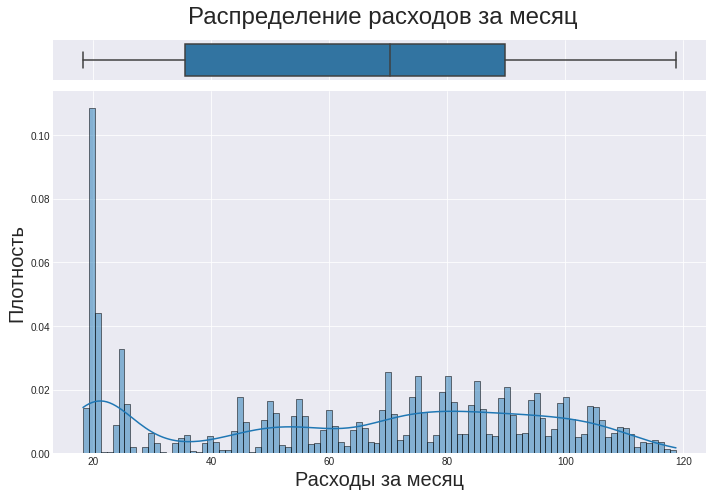

In [53]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
fig.suptitle(' ' * 8 + 'Распределение расходов за месяц', fontsize=24)

sns.boxplot(clients["monthly_charges"], orient="h", ax=ax_box)
sns.histplot(clients["monthly_charges"], bins=100, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel='', ylabel='')
plt.ylabel('Плотность', fontsize=20)
plt.xlabel('Расходы за месяц', fontsize=20);

Сразу заметно, что распределение не нормальное: многие клиенты платят около 20\\$ (по всей видимости, это минимальная плата), и в это же время многие люди платят бóльшие суммы, вплоть до 120\\$. 

Может быть интересным, что значения собираются около десятков: скорее всего, это связано с ценами на услуги и каждая группа значений обозначает набор разных услуг. Можно задуматься о выделении групп клиентов по наборам услуг или использовании "деревянных" моделей.

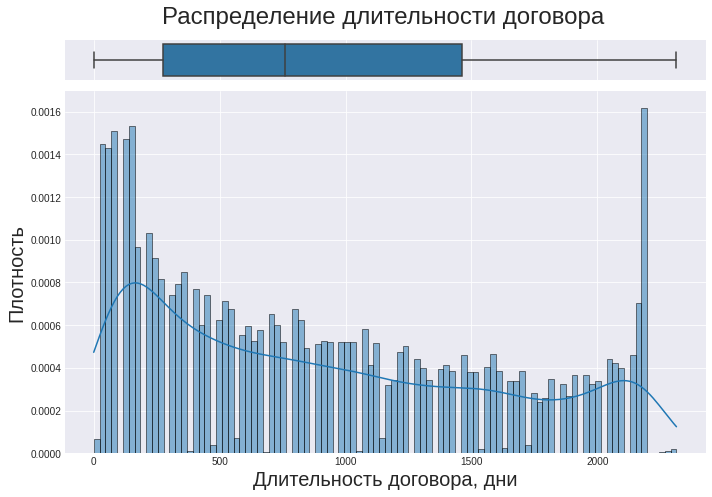

In [54]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
fig.suptitle(' ' * 8 + 'Распределение длительности договора', fontsize=24)

sns.boxplot(clients["period"], orient="h", ax=ax_box)
sns.histplot(clients["period"], bins=100, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel='', ylabel='')
plt.ylabel('Плотность', fontsize=20)
plt.xlabel('Длительность договора, дни', fontsize=20);

Есть группа клиентов с короткой длительностью договора: это могут быть новые абоненты или те, кто быстро ушёл от оператора. С увеличением длительности договора уменьшается количество клиентов с такой длительностью: учитывая, что большинство клиентов не уходило от оператора, это может говорить о росте числа абонентов со временем. Столб больших значений длительности контракта, скорее всего, означает лояльных клиентов, не меняющих оператора с момента появления компании.

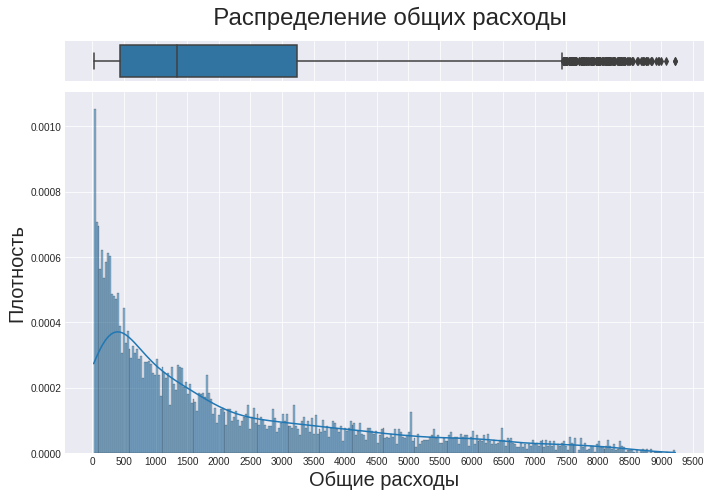

In [55]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
fig.suptitle(' ' * 10 + 'Распределение общих расходы', fontsize=24)

sns.boxplot(clients["total_charges"], orient="h", ax=ax_box)
sns.histplot(clients["total_charges"], bins=300, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel='', ylabel='')
plt.xticks(np.arange(0, 10000, 500))
plt.ylabel('Плотность', fontsize=20)
plt.xlabel('Общие расходы', fontsize=20);

Число клиентов убывает с увеличением общих расходов. Выделяется группа абонентов с расходами менее 500\\$: это могут быть новые клиенты и клиенты с минимальной платой за услуги. Клиентов, потративших более 7500\\$, мало и ящик с усами указывает на то, что эти значения можно считать выбросами. Этими клиентами могут быть абоненты с большой длительностью договора и большими ежемесячными тратами. Также могли произойти ошибки во время сбора данных.

Посмотрим на гистограммы длительности договора и ежемесячных трат клиентов с общими расходами более 7500\\$.

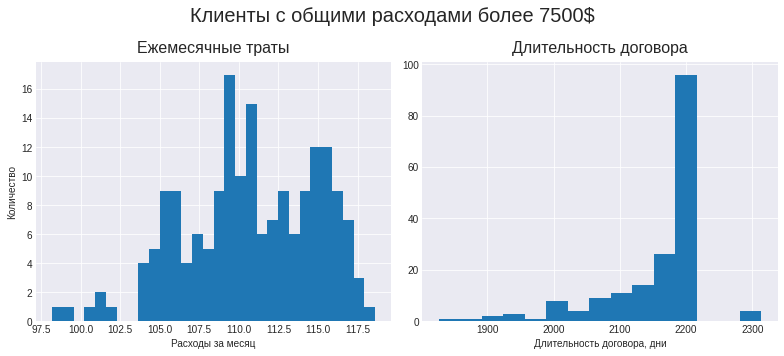

In [56]:
fig, (monthly_charges_hist, period_hist) = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Клиенты с общими расходами более 7500$', fontsize=20)
monthly_charges_hist.hist(clients[clients["total_charges"] >= 7500]['monthly_charges'], bins=30)
period_hist.hist(clients[clients["total_charges"] >= 7500]['period'], bins=15)

monthly_charges_hist.set_title('Ежемесячные траты')
monthly_charges_hist.set_ylabel('Количество')
monthly_charges_hist.set_xlabel('Расходы за месяц')
period_hist.set_title('Длительность договора')
period_hist.set_xlabel('Длительность договора, дни');

Эта группа клиентов действительно имеет ежемесячные расходы и длительность контракта выше среднего. Ошибок в данных здесь нет.

Постороим круговые диаграммы по категориальным признакам, отражающие количество наблюдений.

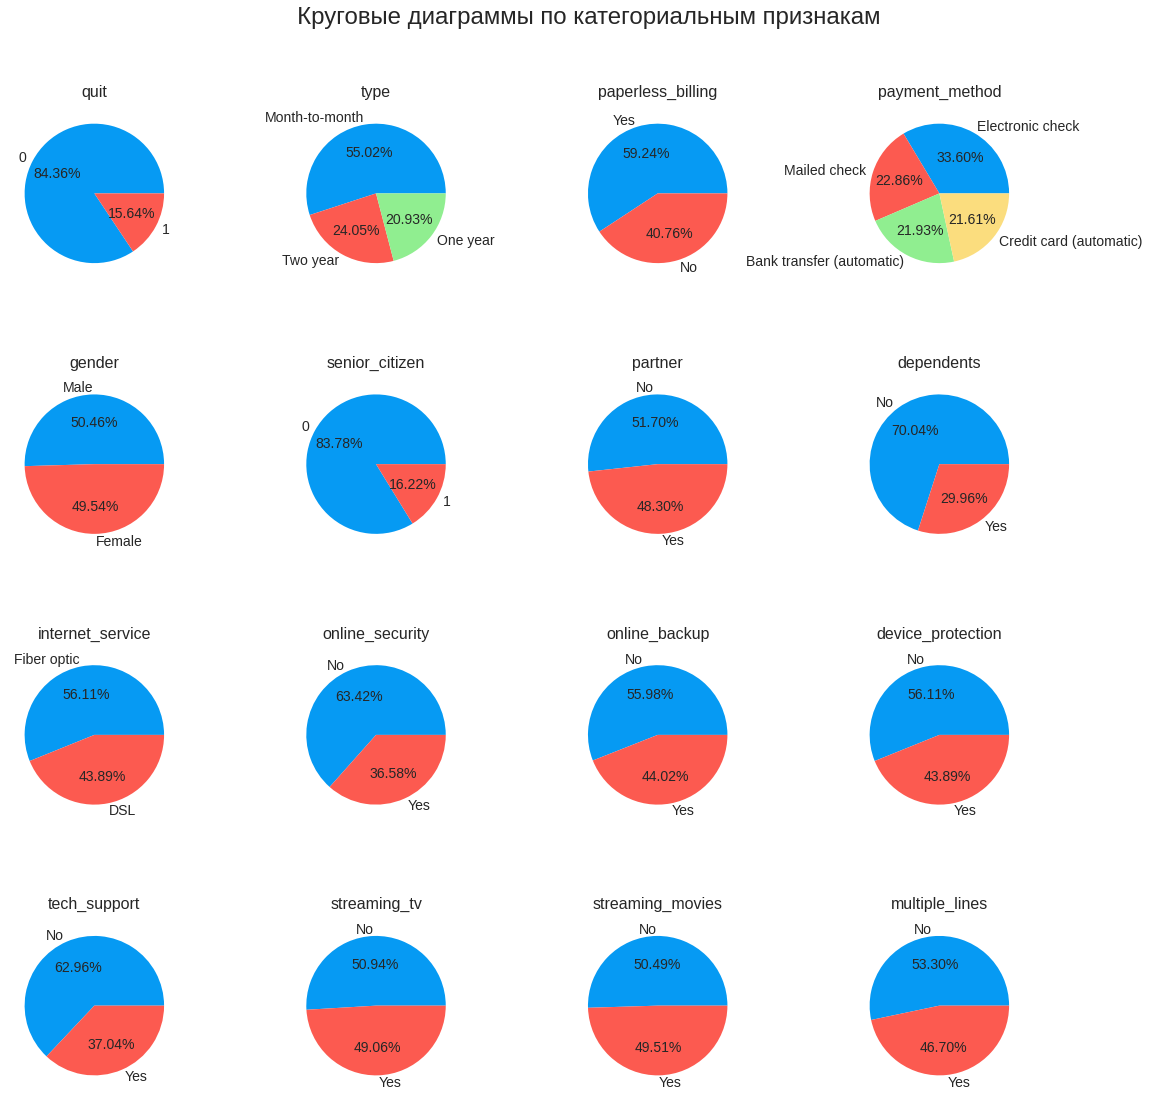

In [57]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle(' '* 5 + 'Круговые диаграммы по категориальным признакам\n', fontsize=24)
cat_cols = clients.select_dtypes(include='category').columns.to_numpy().reshape(4, 4)
for i in range(4):
    for j in range(4):
        value_counts = clients[cat_cols[i, j]].value_counts()
        axes[i, j].pie(value_counts, labels=value_counts.index, 
                       colors=['#069AF3', '#FC5A50', '#90EE90', '#FBDD7E'], 
                       autopct='%.2f%%', textprops={'fontsize': 14})
        axes[i, j].set_title(cat_cols[i, j], fontsize=16)
plt.show()

Большинство клиентов платят за услуги ежемесячно, не являются пенсионерами и не имеют детей. Даже несмотря на пропуски в признаках, означающих подключение дополнительных услуг, видно, что по большей части абоненты ими не пользуются (вероятнее всего, пропуск означает отсутвие подключенной услуги).

Завершим исследовательский анализ заполнением оставшихся пропусков.

In [58]:
for col in clients.columns[clients.isna().any()]:
    clients[col].fillna(clients[col].mode()[0], inplace=True)
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7039 non-null   datetime64[ns]
 1   quit               7039 non-null   category      
 2   type               7039 non-null   category      
 3   paperless_billing  7039 non-null   category      
 4   payment_method     7039 non-null   category      
 5   monthly_charges    7039 non-null   float64       
 6   total_charges      7039 non-null   float64       
 7   period             7039 non-null   float64       
 8   gender             7039 non-null   category      
 9   senior_citizen     7039 non-null   category      
 10  partner            7039 non-null   category      
 11  dependents         7039 non-null   category      
 12  internet_service   7039 non-null   category      
 13  online_security    7039 non-null   category      
 14

*Выводы по исследовательскому анализу:*
- большая часть клиентов не ушла от оператора
- большинство не пользуется дополнительными услугами
- многие клиенты ежемесячно платят около 20\\$ (по всей видимости, это минимальная плата), и в это же время многие люди платят бóльшие суммы, вплоть до 120\\$
- значения ежемесячной платы собираются около десятков: скорее всего, это связано с ценами на услуги и каждая группа значений обозначает набор разных услуг. Можно задуматься о выделении групп клиентов по наборам услуг или использовании "деревянных" моделей.
- распределение длительности договоров показывает рост числа абонентов со временем
- число клиентов убывает с увеличением общих расходов
- выделяется группа абонентов с общими расходами менее 500\\$: это могут быть новые клиенты и клиенты с минимальной платой за услуги
- клиентов, потративших за всё время более 7500\\$, мало
- большинство клиентов платят за услуги ежемесячно, не являются пенсионерами и не имеют детей
- были заполнены оставшиеся после объединения пропуски пропуски в столбцах категориальных признаков

Перед обучением моделей проведём корреляционный анализ.

<a id='corr'></a>
## Корреляционный анализ

Построим матрицу графиков Kernel Density Estimate по всем числовым столбцам для оценки корреляции признаков друг с другом

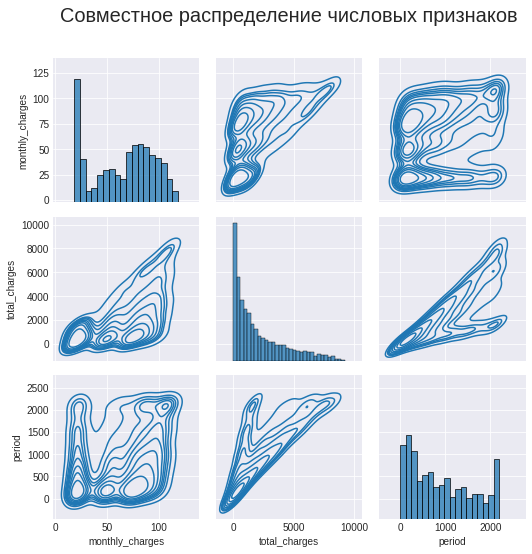

In [59]:
ax = sns.pairplot(clients, kind="kde", diag_kind='hist');
ax.fig.suptitle(' ' * 8 + "Совместное распределение числовых признаков", y=1.02, fontsize=20);

Заметна вполне логичная корреляция между продолжительностью договора и общими затратами абонента. Также объяснимо и её практическое отсутствие между ежемесячными тратами и длительностью контракта.

Воспользуемся матрицей корреляций $\phi_k$

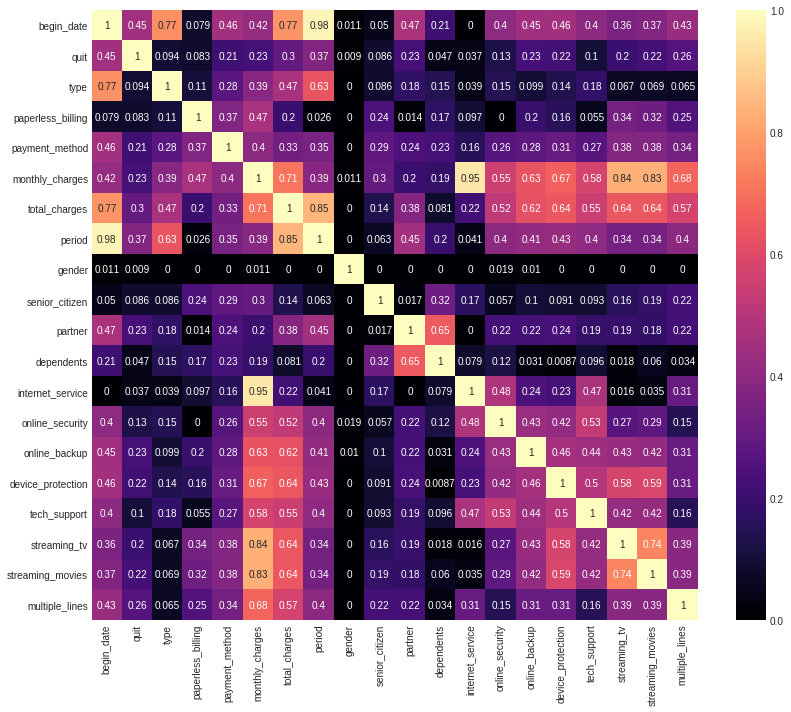

In [60]:
plt.figure(figsize=(12, 10))
sns.heatmap(clients.phik_matrix(interval_cols=clients.select_dtypes(include='number').columns),
            annot=True, cmap='magma');

Выделяется признак `gender`, который не коррелирует ни с одним другим, включая целевой.

Хорошо друг с другом коррелируют признаки, обозначающие подключение дополнительных услуг, и признаки, содержащие информацию об общих и ежемесячных затратах клиентов.

`internet_service` сильно коррелирует с `monthly_charges` и едва коррелирует с остальными признаками – это похоже на утечку признака.

Длительность договора сильно коррелирует с датой начала действия договора. Имеет смысл убрать более сложно интерепретируемый признак `begin_date`, который не даст нам много новой информации во время обучения модели.

Удалим из датафрейма столбцы `gender`, `internet_service` и `begin_date`, которые будут излишними для обучения модели.

In [61]:
clients.drop(['gender', 'internet_service', 'begin_date'], axis=1, inplace=True)
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   quit               7039 non-null   category
 1   type               7039 non-null   category
 2   paperless_billing  7039 non-null   category
 3   payment_method     7039 non-null   category
 4   monthly_charges    7039 non-null   float64 
 5   total_charges      7039 non-null   float64 
 6   period             7039 non-null   float64 
 7   senior_citizen     7039 non-null   category
 8   partner            7039 non-null   category
 9   dependents         7039 non-null   category
 10  online_security    7039 non-null   category
 11  online_backup      7039 non-null   category
 12  device_protection  7039 non-null   category
 13  tech_support       7039 non-null   category
 14  streaming_tv       7039 non-null   category
 15  streaming_movies   7039 non-null   category
 

Мы уже достаточно знаем о данных и зависимостях внутри них и можем приступить к обучению моделей.

<a id='ml'></a>
## Обучение моделей

### Подготовка данных

Разделим данные на тренировочную и тестировочную выборки. В будущем будем считать метрики на кросс-валидации, поэтому отдельную валидационную выборку выделять не будем.

In [62]:
RANDOM_STATE = 160924

X_train, X_test, y_train, y_test = train_test_split(clients.drop('quit', axis=1),
                                                    clients['quit'], test_size=0.25, random_state=RANDOM_STATE)
print(f'X_train - {X_train.shape}')
print(f'y_train - {y_train.shape}')
print(f'X_test - {X_test.shape}')
print(f'y_test - {y_test.shape}')

X_train - (5279, 16)
y_train - (5279,)
X_test - (1760, 16)
y_test - (1760,)


Закодируем целевой признак.

In [63]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Создадим *ColumnTransformer*: категориальные признаки закодируем при помощи *OneHotEncoder*, числовые признаки стандартизуем.

In [64]:
preprocessing = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'),
             X_train.select_dtypes(exclude='number').columns),
        ('num', StandardScaler(), X_train.select_dtypes(include='number').columns)
    ],
    remainder='passthrough'
)

Создадим пайплайн.

In [65]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('model', KNeighborsClassifier())
    ]
)

<a id='hyperparams'></a>
### Моделирование и подбор гиперпараметров

Зададим и переберём разные комбинации моделей и их гиперпараметров. Сейчас сложно определиться с порогом классификации без консультации со специалистом из бизнеса, поэтому будем вычислять метрику *ROC_AUC*, которая покажет нам общее качество модели, учитывая все возможные пороги классификации.

In [66]:
param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__penalty': ['l1', 'l2']
    },
    {
        'model': [LGBMClassifier(verbosity=-1, random_state=RANDOM_STATE)],
        'model__learning_rate': [1e-3, 1e-2, 1e-1, 0.5],
        'model__n_estimators': [300, 500],
        'model__num_iterations': [75, 100, 125]        
    },
    {
        'model': [KNeighborsClassifier()],
        'model__metric': ['cityblock', 'euclidean'],
        'model__n_neighbors': [30, 40, 50],
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [8, 12]
    }
]
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f'ROC_AUC (train) = {roc_auc_score(y_train, grid_search.predict_proba(X_train)[:, 1])}')
print(f'ROC_AUC (test) = {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])}')
model = grid_search.best_estimator_
model

ROC_AUC (train) = 0.9939764533579951
ROC_AUC (test) = 0.9217204987192318


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse=False),
                                                  Index(['type', 'paperless_billing', 'payment_method', 'senior_citizen',
       'partner', 'dependents', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['monthly_charges', 'total_charges', 'period'], dtype='object'))])),
                ('model',
                 LGBMClassifier(n_estimators=300, num_iterations=125,
                                random_state=160924, verbosity=-1))])

Лучшей моделью с *ROC_AUC*, равной на тестовой выборке *0.92*, оказалась *LGBMClassifier* с параметрами:
- *learning_rate*=0.1
- *n_estimators*=300
- *num_iterations*=125

Посмотрим на информацию о пяти лучших моделях

In [67]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__penalty,param_model__learning_rate,param_model__n_estimators,param_model__num_iterations,param_model__metric,...,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,1.811355,0.624922,0.053899,0.043987,"LGBMClassifier(n_estimators=300, num_iteration...",NaN,0.1,300,125,NaN,...,NaN,"{'model': LGBMClassifier(n_estimators=300, num...",0.885931,0.853187,0.829189,0.858489,0.887758,0.862911,0.021902,1
19,1.425749,0.234760,0.033026,0.030772,"LGBMClassifier(n_estimators=300, num_iteration...",NaN,0.1,500,125,NaN,...,NaN,"{'model': LGBMClassifier(n_estimators=300, num...",0.885931,0.853187,0.829189,0.858489,0.887758,0.862911,0.021902,1
18,1.112260,0.047361,0.065263,0.041902,"LGBMClassifier(n_estimators=300, num_iteration...",NaN,0.1,500,100,NaN,...,NaN,"{'model': LGBMClassifier(n_estimators=300, num...",0.881815,0.849113,0.822388,0.847240,0.885845,0.857280,0.023676,3
15,1.070005,0.074972,0.029443,0.032355,"LGBMClassifier(n_estimators=300, num_iteration...",NaN,0.1,300,100,NaN,...,NaN,"{'model': LGBMClassifier(n_estimators=300, num...",0.881815,0.849113,0.822388,0.847240,0.885845,0.857280,0.023676,3
24,1.052720,0.085966,0.065518,0.042710,"LGBMClassifier(n_estimators=300, num_iteration...",NaN,0.5,500,100,NaN,...,NaN,"{'model': LGBMClassifier(n_estimators=300, num...",0.875160,0.846650,0.824449,0.841341,0.869190,0.851358,0.018607,5


Модели градиентного бустинга стабильно справляются с задачей лучше других.

Проведём анализ лучшей модели.

<a id='model_analysis'></a>
### Анализ модели

Посмотрим, смогла ли модель добиться высокого *accuracy*.

In [68]:
print(f'Accuracy (test): {accuracy_score(y_test, model.predict(X_test))}')

Accuracy (test): 0.8960227272727272


*Accuracy* на тестовой выборке достаточно высока и близка к метрике на тренировочной выборке, которая в данном случае близка к идеальной.

Посмотрим также на *F1-score*, *precision* и *recall*.

In [69]:
print(f'F1-score (test): {f1_score(y_test, model.predict(X_test))}\n')
print(f'Precision (test): {precision_score(y_test, model.predict(X_test))}\n')
print(f'Recall (test): {recall_score(y_test, model.predict(X_test))}')

F1-score (test): 0.6179540709812108

Precision (test): 0.8176795580110497

Recall (test): 0.4966442953020134



Дополонительно выведем матрицу ошибок и ROC-кривую.

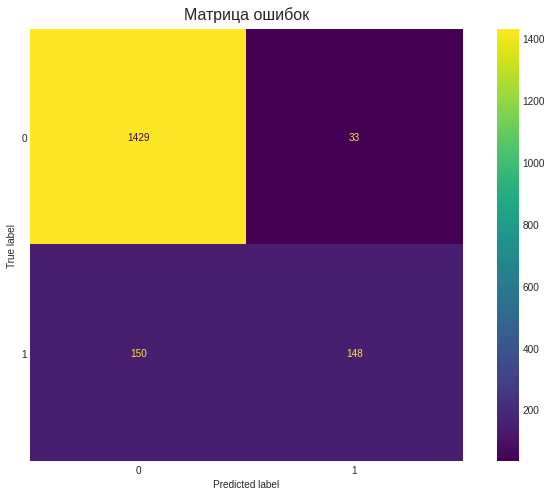

In [70]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Матрица ошибок')
plt.grid(visible=False);

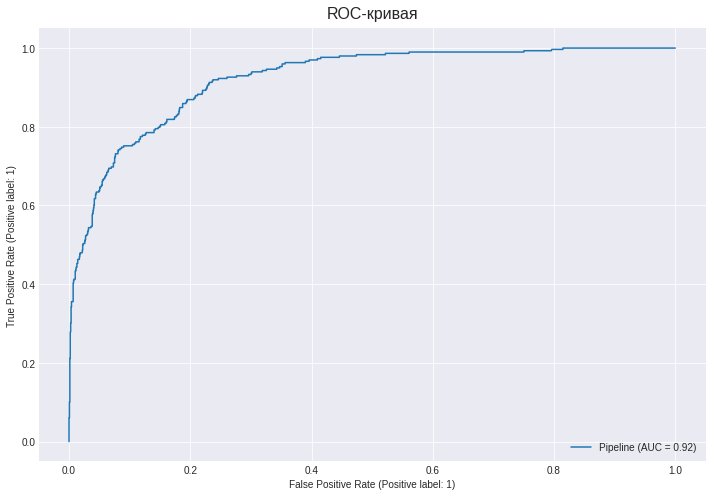

In [71]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC-кривая');

Все вычисленные метрики идеальны на тренировочной выборке. В случае тестовой наблюдается разброс, что является сигналом о переобучении модели. Тем не менее, результаты достаточно хороши и позволят качественно выполнять поставленную задачу прогнозирования оттока абонентов.

Стоит заметить, что модель достаточно точно определяет, уйдёт ли клиент, но находит **всех** уходящих клиентов хуже. В зависимости от дальнейших пожеланий заказчика можно максимизировать ту или иную метрику, изменив порог классификации (делать это лучше на отдельной валидационной выборке).

Рассмотрим столбчатую диаграмму, отражающую общий вклад признаков в прогнозы модели.

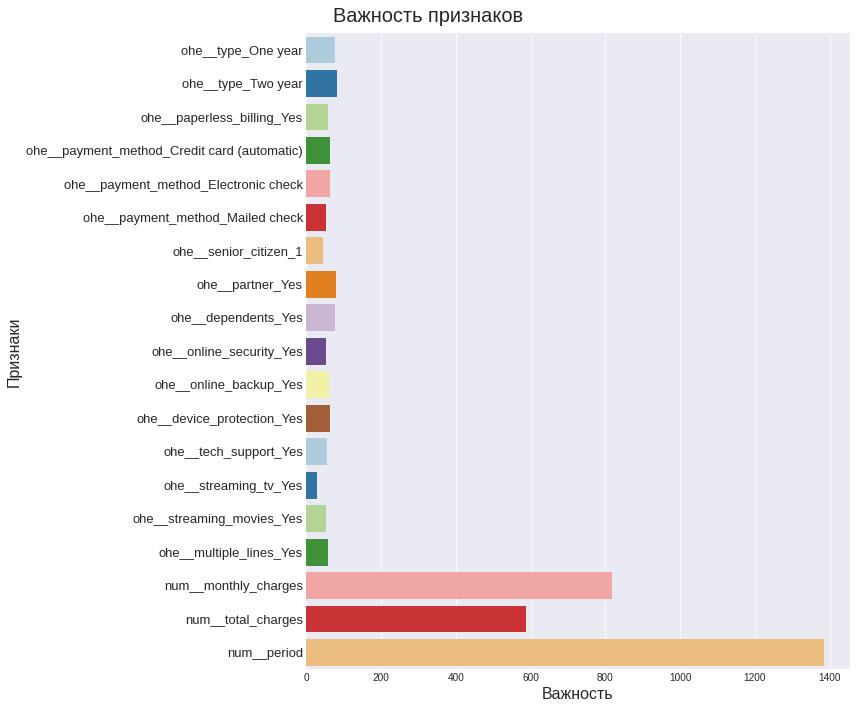

In [72]:
plt.figure(figsize=(12, 10))

sns.barplot(x=model['model'].feature_importances_, y=model['preprocessing'].get_feature_names_out(), palette='Paired')

plt.suptitle('Важность признаков', fontsize=20)
plt.yticks(fontsize=13)
plt.xlabel('Важность', fontsize=16)
plt.ylabel('Признаки', fontsize=16);

Наибольший вклад оказали численные признаки, причём длительность договора играет главную роль в предсказании. Можно смело предположить, что лояльные клиенты, остающиеся с оператором долгое время меняют его не очень охотно.

Из категориальных признаков заметно наибольшее влияние `partner` и `dependents`: возможно, оператор предоставляет выгодные (или не очень выгодные) условия для семейного пользования, или существуют другие причины изменить отношение к оператору из-за наличия семьи.

В целом, категориальные признаки играют не самую важную роль из-за редкости подключённых дополнительных услуг или слабой важности признака. Действительно имеет смысл предоставлять скидки на опциональные услуги клиентам, которые с большой вероятностью склонны уйти: это может позволить показать полезность сервисов и повысить лояльность абонента.

<a id='summary'></a>
## Вывод

Была построена модель, предсказывающая вероятность ухода клиента от оператора связи.

***Исходные данные и предобработка:***

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на *1 февраля 2020 года*.

*В ходе предобработки столбцы в `contract_new` были приведены к правильным типам данных, а пропуски в них заполнены. Также был добавлен столбец `period` с длительностью договора и выделен столбец с целевой переменной. В остальных датафреймах неожиданностей не было обнаружено. Названия столбцов были приведены к snake_case.*

Для дальнейшей работы с данными датафреймы были объединены.

***Исследовательский анализ:***
- большая часть клиентов не ушла от оператора
- большинство не пользуется дополнительными услугами
- многие клиенты ежемесячно платят около 20\\$ (по всей видимости, это минимальная плата), и в это же время многие люди платят бóльшие суммы, вплоть до 120\\$
- значения ежемесячной платы собираются около десятков: скорее всего, это связано с ценами на услуги и каждая группа значений обозначает набор разных услуг. Можно задуматься о выделении групп клиентов по наборам услуг или использовании "деревянных" моделей.
- распределение длительности договоров показывает рост числа абонентов со временем
- число клиентов убывает с увеличением общих расходов
- выделяется группа абонентов с общими расходами менее 500\\$: это могут быть новые клиенты и клиенты с минимальной платой за услуги
- клиентов, потративших за всё время более 7500\\$, мало
- большинство клиентов платят за услуги ежемесячно, не являются пенсионерами и не имеют детей
- были заполнены оставшиеся после объединения пропуски в столбцах категориальных признаков

***Корреляционный анализ:***
* выделяется признак `gender`, который не коррелирует ни с одним другим, включая целевой
* хорошо друг с другом коррелируют признаки, обозначающие подключение дополнительных услуг, и признаки, содержащие информацию об общих и ежемесячных затратах клиентов
* `internet_service` сильно коррелирует с `monthly_charges` и едва коррелирует с остальными признаками – это похоже на утечку признака
* Длительность договора сильно коррелирует с датой начала действия договора. Имеет смысл убрать более сложно интерепретируемый признак `begin_date`, который не даст нам много новой информации во время обучения модели.

Столбцы `gender`, `internet_service` и `begin_date` были удалены из датафрейма, так как были бы излишними для обучения модели.

***Моделирование:***

Были заданы и перебраны разные комбинации моделей и их гиперпараметров. Без консультации со специалистом из бизнеса сложно определиться с порогом классификации, поэтому основной метрикой была *ROC_AUC*, которая показывает общее качество модели, учитывая все возможные пороги классификации.

Числовые признаки были масштабированы при помощи *StandardScaler*. Категориальные признаки были закодированы *OneHotEncoder*.

*В качестве лучшей была выбрана модель градиентного бустинга **LGBMClassifier** со следующими параметрами:*
* *learning_rate*=0.1
* *n_estimators*=300
* *num_iterations*=125
* *ROC_AUC* на тренировочной выборке приблизительно равна *1*, на тестовой выборке – *0.92*

***Анализ модели:***

Все вычисленные метрики идеальны на тренировочной выборке. В случае тестовой наблюдается разброс, что является сигналом о переобучении модели. Тем не менее, результаты достаточно хороши и позволят качественно выполнять поставленную задачу прогнозирования оттока абонентов.

Модель достаточно точно определяет, уйдёт ли клиент, но находит **всех** уходящих клиентов хуже. В зависимости от дальнейших пожеланий заказчика можно максимизировать ту или иную метрику, изменив порог классификации (делать это лучше на отдельной валидационной выборке).

Наибольший вклад оказали численные признаки, причём длительность договора играет главную роль в предсказании. Можно смело предположить, что лояльные клиенты, остающиеся с оператором долгое время меняют его не очень охотно.

Из категориальных признаков заметно наибольшее влияние `partner` и `dependents`: возможно, оператор предоставляет выгодные (или не очень выгодные) условия для семейного пользования, или существуют другие причины изменить отношение к оператору из-за наличия семьи.

В целом, категориальные признаки играют не самую важную роль из-за редкости подключённых дополнительных услуг или слабой важности признака.

Для лучшего качества прогноза необходимо продолжать собирать данные и, желательно, обогащать их бóльшим количеством признаков.

***Рекомендации заказчику***

Обученная модель способна корректно прогнозировать отток клиентов оператора связи с целью его предотвращения. Оценённых моделью как готовыми разорвать договор клиентов стоит рассматривать более тщательно и предлагать им персональные условия.  Имеет смысл предоставлять таким клиентам скидки на опциональные услуги: это может позволить показать полезность сервисов и повысить лояльность абонента. Иные способы повысить лояльность клиента также должны помочь продлить длительность действия  выгодного для компании договора.